In [ ]:
!git clone https://github.com/Omenranr/Fault-prognostic-of-turbofan-engines

Cloning into 'Fault-prognostic-of-turbofan-engines'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 41 (delta 2), reused 37 (delta 1), pack-reused 0
Unpacking objects: 100% (41/41), done.


In [ ]:
cd Fault-prognostic-of-turbofan-engines

/content/Fault-prognostic-of-turbofan-engines/Fault-prognostic-of-turbofan-engines


this code is implementing this paper: 

1. T. Wang, J. Yu, D. Siegel, J. Lee, "A similarity-based prognostics approach for remaining useful life estimation of engineered systems", Proc. Int. Conf. Prognostics Health Manage., pp. 1-6, Oct. 2008.


# Fault prognostic of turbofan engines

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing , HoltWintersResults
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics.pairwise import euclidean_distances

#Data Exploration

In [ ]:
# path to dataset 
dirname = os.getcwd()
data_path = os.path.join(dirname, 'Data', 'train_FD001.txt')
test_data_path = os.path.join(dirname, 'Data', 'test_FD001.txt')
# column names for the dataset
# op_cond refers to operational condition, sn: sensor
columns = ['engine', 'time', 'op_cond_1', 'op_cond_2', 'op_cond_3']
columns = columns + ['sn_{}'.format(s + 1) for s in range(21)]

In [ ]:
df = pd.read_csv(data_path, header = None, names = columns, delim_whitespace = True, index_col = 0)
test_df = pd.read_csv(test_data_path, header = None, names = columns, delim_whitespace=True, index_col = 0)

## Look at Values of Data Generally

In [ ]:
df

,time,op_cond_1,op_cond_2,op_cond_3,sn_1,sn_2,sn_3,sn_4,sn_5,sn_6,sn_7,sn_8,sn_9,sn_10,sn_11,sn_12,sn_13,sn_14,sn_15,sn_16,sn_17,sn_18,sn_19,sn_20,sn_21
engine,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333


In [ ]:
df.describe()

,time,op_cond_1,op_cond_2,op_cond_3,sn_1,sn_2,sn_3,sn_4,sn_5,sn_6,sn_7,sn_8,sn_9,sn_10,sn_11,sn_12,sn_13,sn_14,sn_15,sn_16,sn_17,sn_18,sn_19,sn_20,sn_21
count,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.300000e+00,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092,0.070985,22.082880,4.660829e-13,0.267087,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.300000e+00,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.300000e+00,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.300000e+00,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.300000e+00,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


##Data visualization

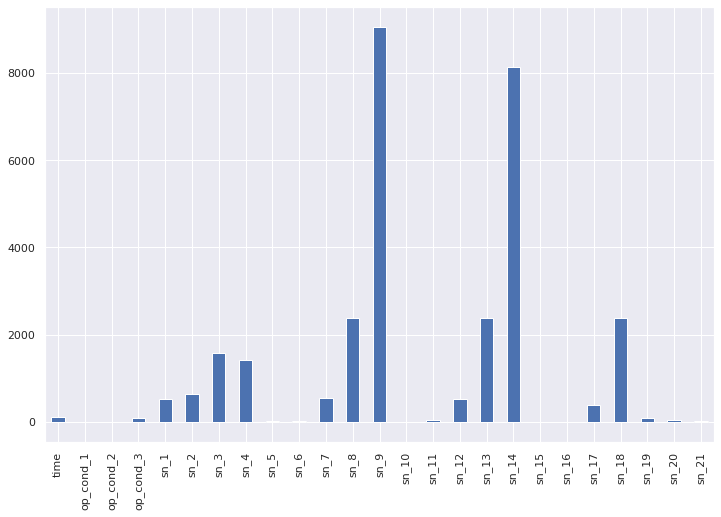

In [ ]:
sns.set() 
df.mean().plot.bar(figsize = (12, 8));

## Examine Correlation Between Columns

In [ ]:
correlation = testdf.drop('time', axis = 1).corr()

In [ ]:
def plot_correlation(correlation, figure_size = (11, 9), title = None):

    sns.set(style="white")

    fig, ax = plt.subplots(figsize = figure_size)
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    
    # correlation heatmap
    sns.heatmap(correlation, cmap = cmap, vmax = 1, center = 0,
                square = True, linewidths = .5, cbar_kws = {"shrink": .5})
    if title != None :
        plt.title(title, fontsize = 18)
    return fig

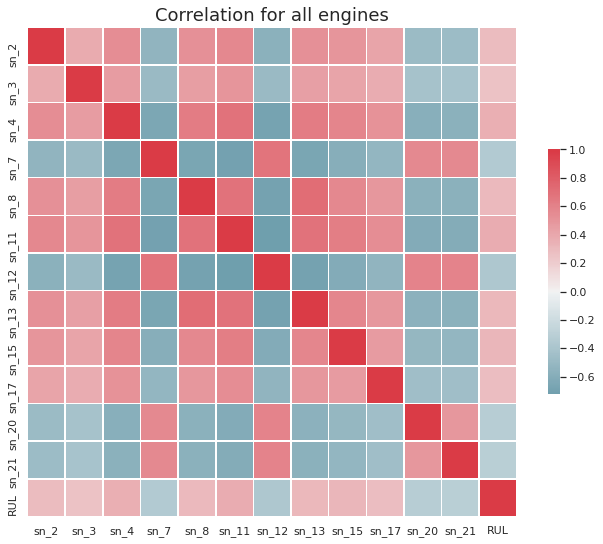

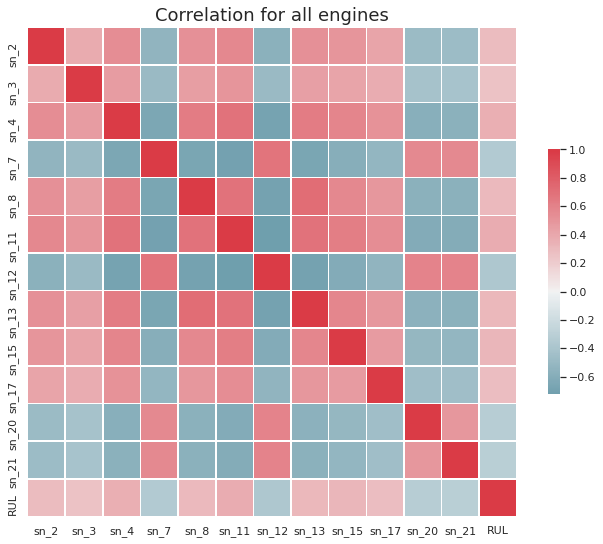

In [ ]:
plot_correlation(correlation, title='Correlation for all engines')

### Find high correlation pairs

In [ ]:
def high_correlation_pairs(df, threshold):

    correlation = df.drop('time', axis = 1).corr()
    high_corr_pairs = []
    correlation_df = pd.DataFrame(np.tril(correlation.values), columns = correlation.columns, index = correlation.index)

    # check  the correlation between every pair of columns in the corr and keeps the high ones
    for i, col in enumerate(correlation_df):
        col_corr = correlation_df[col].iloc[i+1:] # this slicing ensures ignoring self_corr and duplicates due to symmetry
        # bool mask for pairs with high corr with col
        pairs = col_corr.apply(lambda x: abs(x)) > threshold 
        idx_pairs = col_corr[pairs].index

        # create list of high corr pairs
        for idx, corr in zip(idx_pairs, col_corr[pairs].values):
            high_corr_pairs.append((col, idx, corr))
    
    return high_corr_pairs

In [ ]:
threshold = 0.9
correlation_pairs = high_correlation_pairs(df, threshold)
for c in correlation_pairs:
    print(c)

('sn_1', 'sn_5', 1.0)
('sn_1', 'sn_10', 1.0)
('sn_1', 'sn_16', 1.0)
('sn_5', 'sn_10', 1.0)
('sn_5', 'sn_16', 1.0)
('sn_9', 'sn_14', 0.9631566003059564)
('sn_10', 'sn_16', 1.0)


the above sensors are prefectly correlated with each others. which means that I can remove some columns for the analysis

### plot variables distribution

In [ ]:
def plot_distribution(df, engine_num=None):
    columns = df.columns
    n_cols = min(len(columns), 5)
    n_rows = int(np.ceil(len(columns) / n_cols))
    
    sns.set()
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
    axes = axes.flatten()
    if engine_num != None: 
        fig.suptitle('distributions for engine #: {}'.format(engine_num))
        df_plot = df.loc[engine_num]
    else: 
        fig.suptitle('distributions for all engines')
        df_plot = df
    for col, ax in zip(columns, axes):
        ax = sns.distplot(df_plot[col], ax=ax, label=col)
        ax.legend(loc=1)
    return fig

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

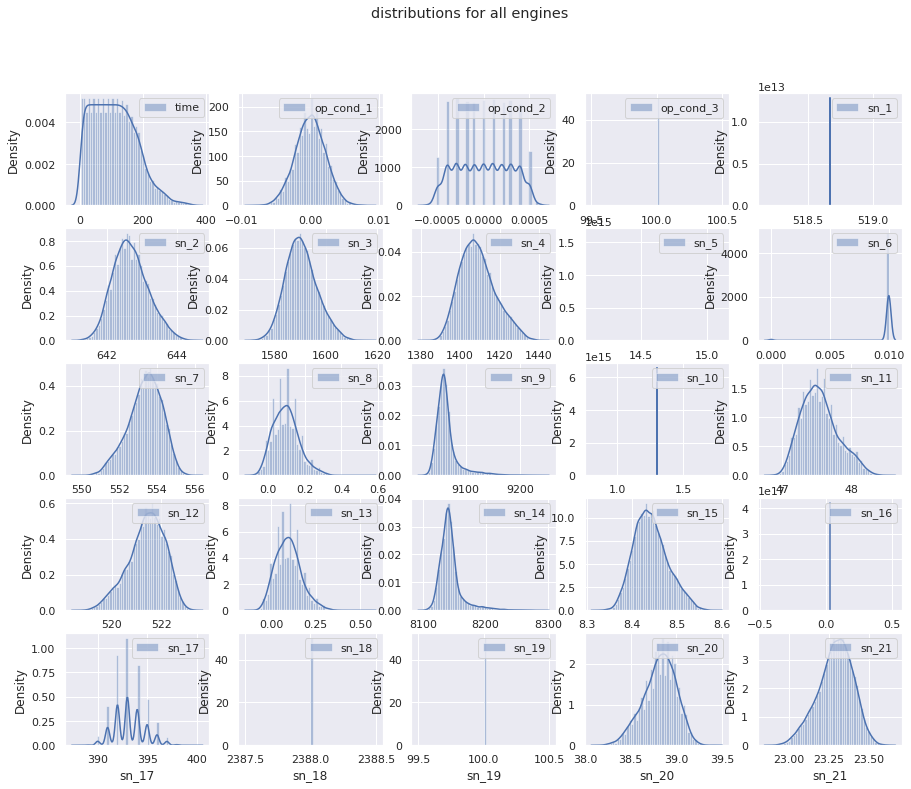

In [ ]:
corr_fig = plot_distribution(df)

### remove constant variables

In [ ]:
constant_columns = [col for col in df.columns if (df[col].std() <= .0001*df[col].mean()) & (df[col].nunique() <= 4)]
print('constant columns are:\n', constant_columns)

constant columns are:
 ['op_cond_3', 'sn_1', 'sn_5', 'sn_6', 'sn_10', 'sn_16', 'sn_18', 'sn_19']


In [ ]:
testdf

,time,sn_2,sn_3,sn_4,sn_7,sn_8,sn_11,sn_12,sn_13,sn_15,sn_17,sn_20,sn_21,RUL
engine,,,,,,,,,,,,,,
1,1,643.02,1585.29,1398.21,553.90,2388.04,47.20,521.72,2388.03,8.4052,392,38.86,23.3735,-30.0
1,2,641.71,1588.45,1395.42,554.85,2388.01,47.50,522.16,2388.06,8.3803,393,39.02,23.3916,-29.0
1,3,642.46,1586.94,1401.34,554.11,2388.05,47.50,521.97,2388.03,8.4441,393,39.08,23.4166,-28.0
1,4,642.44,1584.12,1406.42,554.07,2388.03,47.28,521.38,2388.05,8.3917,391,39.00,23.3737,-27.0
1,5,642.51,1587.19,1401.92,554.16,2388.01,47.31,522.15,2388.03,8.4031,390,38.99,23.4130,-26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,194,643.24,1599.45,1415.79,553.41,2388.02,47.69,520.69,2388.00,8.4715,394,38.65,23.1974,-4.0
100,195,643.22,1595.69,1422.05,553.22,2388.05,47.60,521.05,2388.09,8.4512,395,38.57,23.2771,-3.0
100,196,643.44,1593.15,1406.82,553.04,2388.11,47.57,521.18,2388.04,8.4569,395,38.62,23.2051,-2.0


In [ ]:
df

,time,op_cond_1,op_cond_2,sn_2,sn_3,sn_4,sn_7,sn_8,sn_9,sn_11,sn_12,sn_13,sn_14,sn_15,sn_17,sn_20,sn_21
engine,,,,,,,,,,,,,,,,,
1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333


In [ ]:
testdf.to_csv("test_data.csv")

In [ ]:
df.drop(columns=constant_columns, axis=1, inplace=True)
testdf.drop(columns=constant_columns, axis=1, inplace=True)

KeyError: ignored

let's look at the high correlation columns right now agian 

In [ ]:
corr_pairs = high_correlation_pairs(df, threshold)
print('high correlation columns all engines:')
for c in corr_pairs:
    print(c)

### pair plots for all engines

In [ ]:
def plot_pair(df, col1, col2, engine_num=None): 
    sns.set()
    columns = df.iloc[:, col1:col2].columns.values.tolist()
    
    if engine_num == None: 
        pairplot_df = df.iloc[:, col1:col2]
        print('plotting pairs for all engines and columns: {}'.format(columns))
        sns.pairplot(pairplot_df, diag_kind = 'kde', height=2.5);
    else:
        pairplot_df = df.loc[engine_num].iloc[:, col1:col2]
        sns.pairplot(pairplot_df, diag_kind = 'kde', height=2.5);
        print('Pair plot for {} engines, for columns: {}'.format(engine_num, columns))

In [ ]:
col1, col2 = 1, -1
plot_pair(df, col1, col2, engine_num=None)

### pair plots for one engine

In [ ]:
col1, col2 = 1, 5
engine_num = 1
plot_pair(df, col1, col2, engine_num)

From the above pairplots we can deduce that:
1. the distribution of almost all variables is single skewed gaussian.
2. op_cond_2 and sn_17 seem to be discrete variables and not continuous. So removing them will be probably benefic

### time series plotting 

In [ ]:
def plot_time_series(df, engine_num=1, figsize = (19, 17)):

    timeseries = df.loc[engine_num].copy()
    time = timeseries['time']
    timeseries.drop(labels=['time'], axis=1, inplace=True)
    columns = timeseries.columns
    
    # plotting
    fig, axes = plt.subplots(len(columns), 1, figsize=figsize)
    for column, ax in zip(columns, axes):
        ax.plot(time, timeseries[column], label=column)
        ax.legend(loc=2)
        
    # figure title    
    fig.suptitle('Engine N°: {}'.format(engine_num))
    return fig

In [ ]:
plot_time_series(df, 1)

### Calculate RUL at each time instance and add it to df

In [ ]:
from tqdm import tqdm

In [ ]:
#Calculating RUL for train set
for id in tqdm(df.index.unique()):
    df.loc[id, 'RUL'] = df.loc[id]['time'].apply(lambda x: x - df.loc[id]['time'].max())

100%|██████████| 100/100 [00:05<00:00, 19.42it/s]


In [ ]:
#Calculating RUL for test set
for id in tqdm(testdf.index.unique()):
    testdf.loc[id, 'RUL'] = testdf.loc[id]['time'].apply(lambda x: x - testdf.loc[id]['time'].max())

100%|██████████| 100/100 [00:03<00:00, 30.41it/s]


In [ ]:
def plot_all_timeseries(df):

    # preparing dataframes
    timeseries = df.copy()
    timeseries.drop(labels=['time'], axis=1, inplace=True)
    columns = timeseries.columns
    # plotting
    fig, axes = plt.subplots(len(columns) - 1, 1, figsize=(19,17))
    for column, ax in zip(columns, axes):
        if column == 'RUL':
            continue 
        font = {'fontsize': 12}
        ax.set_title(column, loc = 'left', fontdict = font)
        for engine_id in timeseries.index.unique():
            time = timeseries.loc[engine_id, 'RUL']
            ax.plot(time, timeseries.loc[engine_id, column], label=column)  
    fig.suptitle("All engine's timeseries")
    return fig

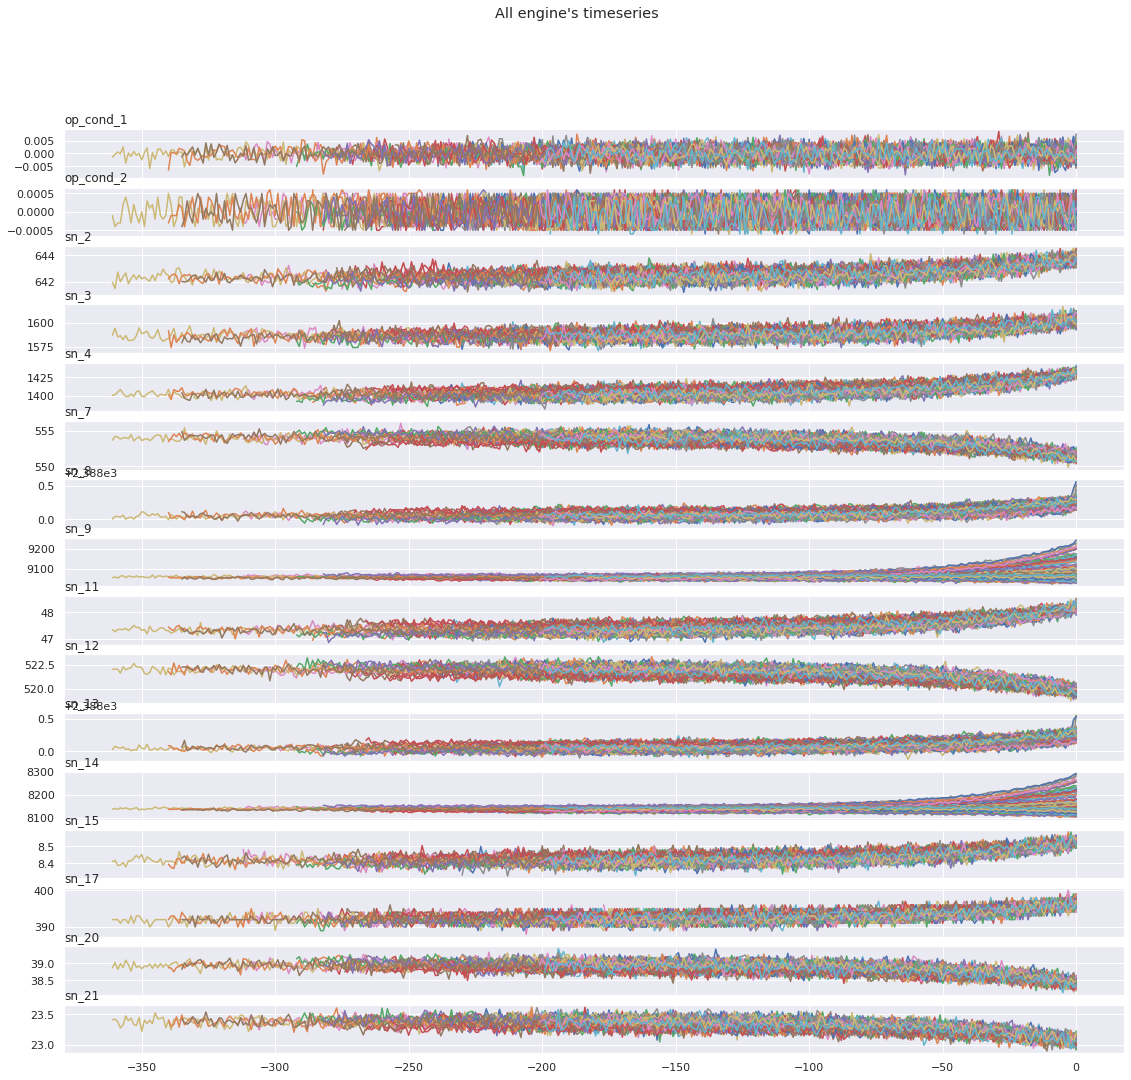

In [ ]:
fig = plot_all_timeseries(df)

From the time series plot of all engine, we can find the below takeaways 

1. columns [op_cond_1, op_cond_2] don't contain any information (random noise), so we can remove them.
2. from columns [sn_9 , sn_14] we can see that it depends on each engine since the amplitudes are spread over.
3. For other columns we can see that the values follow trends which means that the information they contain is probably useful for predicting the RULs.

# HI generation + Similarity based RUL selection

## Data Preprocessing

### Remove no apparent trend columns

In [ ]:
df.drop(['op_cond_1','op_cond_2' , 'sn_9' , 'sn_14'], axis=1, inplace=True) #for training set
testdf.drop(['op_cond_1','op_cond_2' , 'sn_9' , 'sn_14'], axis=1, inplace=True) #for test set

KeyError: ignored

### Normalization

In [ ]:
columns = df.columns.values[1:-1]
#train set
train_sensor_data = df[columns].values
#test set
test_sensor_data = testdf[columns].values

In [ ]:
columns

array(['sn_2', 'sn_3', 'sn_4', 'sn_7', 'sn_8', 'sn_11', 'sn_12', 'sn_13',
       'sn_15', 'sn_17', 'sn_20', 'sn_21'], dtype=object)

In [ ]:
print('Remaining sensors are: \n{}'.format(columns))

Remaining sensors are: 
['sn_2' 'sn_3' 'sn_4' 'sn_7' 'sn_8' 'sn_11' 'sn_12' 'sn_13' 'sn_15'
 'sn_17' 'sn_20' 'sn_21']


In [ ]:
#train set normalization
standard_scale = StandardScaler()
standard_sensors = standard_scale.fit_transform(train_sensor_data)
#test set normalization
standard_scale_test = StandardScaler()
standard_sensors_test = standard_scale_test.fit_transform(test_sensor_data)

In [ ]:
np.savetxt("train_data.csv", standard_sensors, delimiter=",")

In [ ]:
np.savetxt("test_data.csv", standard_sensors_test, delimiter=",")

### fit linear regression to the sensor data to get the slopes 

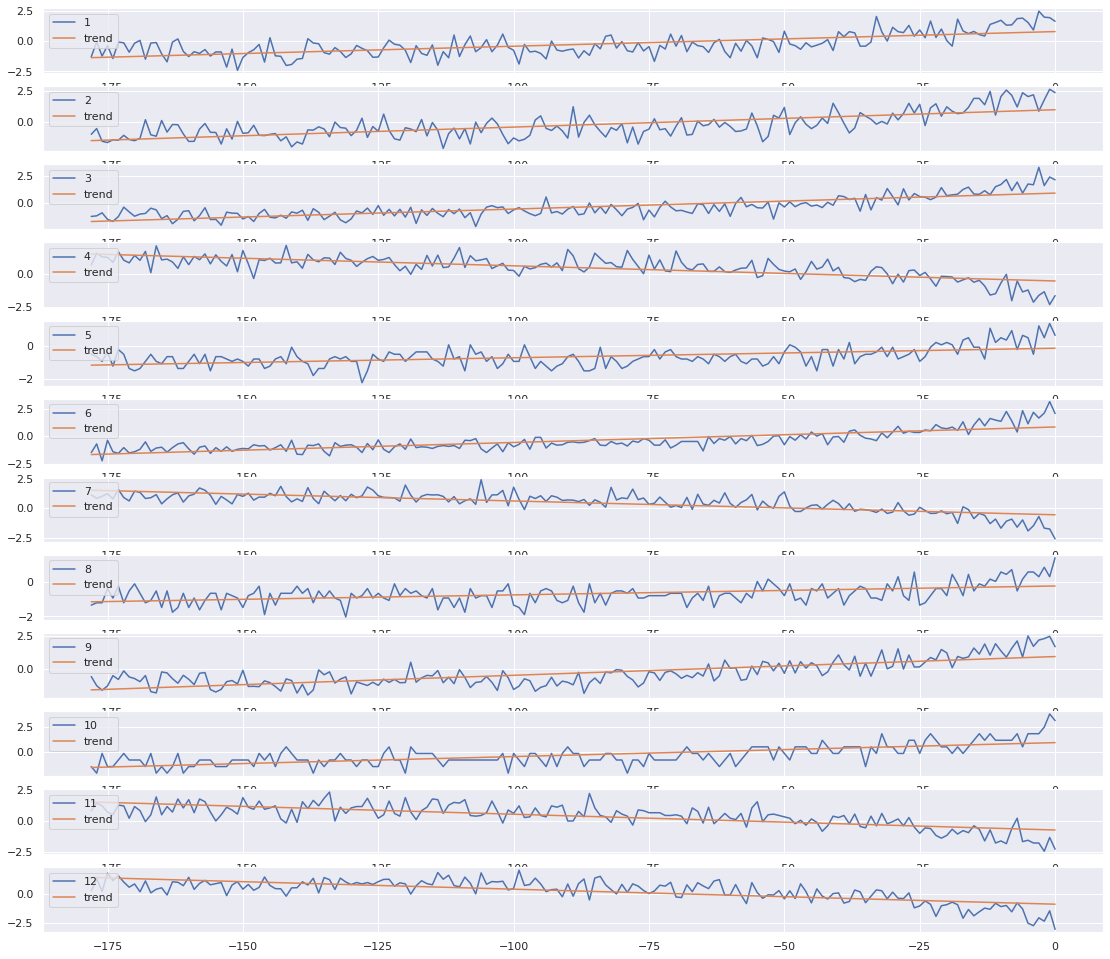

In [ ]:
lin_model = LinearRegression()
engine_num = 3
x = df.loc[engine_num, 'RUL'].values
row_name = df.loc[engine_num].iloc[-1].name
row_sl = df.index.get_loc(row_name)
y = standard_sensors[row_sl]
lin_model.fit(x.reshape(-1, 1), y)
y_hat = lin_model.predict(x.reshape(-1, 1))

# plotting
time = df.loc[engine_num,'RUL']
cols = df.columns[1:-1]
fig, axes = plt.subplots(len(cols), 1, figsize=(19,17))
for col, ax in zip(range(standard_sensors.shape[1]), axes):
    ax.plot(time,standard_sensors[row_sl,col],label=col+1)
    ax.plot(time,y_hat[:,col],label='trend')
    ax.legend(loc=2)

In [ ]:
def lin_slopes(sensors, df, engine_num):
    '''
    description: gives sensors slope coefs for a specific engine
    '''
    linear_reg = LinearRegression()
    X_RUL = df.loc[engine_num, 'RUL'].values
    row_name = df.loc[engine_num].iloc[-1].name
    row_slice = df.index.get_loc(row_name) # row slice to get numpy index 
    y = sensors[row_slice] # sensor values for the specifc engine
    linear_reg.fit(X_RUL.reshape(-1, 1), y)
    slopes = linear_reg.coef_[:, 0]
    return slopes

In [ ]:
# Calculating coefs for all engines (Train set)
engines = df.index.unique().values
slopes = np.empty((standard_sensors.shape[1], len(engines)))
for i, engine in enumerate(engines):
    slopes[:, i] = lin_slopes(standard_sensors, df, engine) 

In [ ]:
# Calculating coefs for all engines (Test set)
engines = testdf.index.unique().values
slopes_test = np.empty((standard_sensors_test.shape[1], len(engines)))
for i, engine in enumerate(engines):
    slopes_test[:, i] = lin_slopes(standard_sensors, testdf, engine) 

In [ ]:
slopes[0, 0]

0.01214620757114335

In [ ]:
# creating slopes_df (Train set)
slopes_df = pd.DataFrame(slopes.T, index=engines, columns = columns)
# creating slopes_df (Test set)
slopes_df_test = pd.DataFrame(slopes_test.T, index=engines, columns = columns)

In [ ]:
slopes_df.describe()

,sn_2,sn_3,sn_4,sn_7,sn_8,sn_11,sn_12,sn_13,sn_15,sn_17,sn_20,sn_21
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.010975,0.010625,0.012324,-0.011917,0.010246,0.012641,-0.012249,0.010271,0.011670,0.010988,-0.011533,-0.011540
std,0.002842,0.002459,0.003010,0.003444,0.005552,0.003387,0.003736,0.005540,0.002884,0.002383,0.002899,0.002842
min,0.005116,0.005192,0.007006,-0.020537,0.000914,0.006454,-0.022150,0.000765,0.006841,0.006122,-0.019988,-0.019546
25%,0.009114,0.008862,0.010195,-0.013892,0.006127,0.010143,-0.014874,0.006001,0.009384,0.009305,-0.013105,-0.013138
50%,0.010601,0.010617,0.012143,-0.011197,0.009827,0.012485,-0.011462,0.009734,0.011378,0.010961,-0.011151,-0.011283
75%,0.012328,0.012220,0.013796,-0.009588,0.014121,0.014375,-0.009409,0.013808,0.013416,0.012324,-0.009329,-0.009657
max,0.018116,0.016361,0.019765,-0.005189,0.022287,0.021425,-0.005428,0.023741,0.019327,0.016854,-0.006681,-0.005770


In [ ]:
# index of highest to lowest abs(slope) for each signal 
sorted_slopes_index = np.argsort(np.abs(slopes.mean(axis=1)))[::-1]
sorted_slopes_index_test = np.argsort(np.abs(slopes_test.mean(axis=1)))[::-1]

In [ ]:
sorted_slopes_index, sorted_slopes_index_test

(array([ 5,  2,  6,  3,  8, 11, 10,  9,  0,  1,  7,  4]),
 array([ 4,  7,  3, 11,  8,  6,  5, 10,  2,  0,  1,  9]))

In [ ]:
print('Sorted trend magnitude:\n{}'.format(columns[sorted_slopes_index]))

Sorted trend magnitude:
['sn_11' 'sn_4' 'sn_12' 'sn_7' 'sn_15' 'sn_21' 'sn_20' 'sn_17' 'sn_2'
 'sn_3' 'sn_13' 'sn_8']


### Applying PCA

In [ ]:
pca_train = PCA()
pca_train.fit(standard_sensors)
pca_test = PCA()
pca_test.fit(standard_sensors_test)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
print("PCA explained variance ratio for train set: \n", 100 * pca_train.explained_variance_ratio_)
print("PCA explained variance ratio for test set: \n", 100 * pca_test.explained_variance_ratio_)

PCA explained variance ratio for train set: 
 [74.02229299  4.09808175  3.35440958  3.02407954  2.79358664  2.54795856
  2.39672973  1.91627556  1.70348529  1.47228614  1.43837368  1.23244054]
PCA explained variance ratio for test set: 
 [59.67618541  5.44575092  4.92627485  4.57989123  4.22907512  4.09339014
  3.8889055   3.15690053  2.85340404  2.52951359  2.33396682  2.28674186]


### PCA with highest 6 sensors in terms of linear trend slope

In [ ]:
#Training set
slopes_keep_n = 6
pca_keep_components = 3
high_trend_sensors = standard_sensors[:, sorted_slopes_index[0:slopes_keep_n]]
pca_high_train = PCA(pca_keep_components, whiten=True)
pca_high_train.fit(high_trend_sensors)
#Testing set
high_trend_sensors_test = standard_sensors_test[:, sorted_slopes_index_test[0:slopes_keep_n]]
pca_high_test = PCA(pca_keep_components, whiten=True)
pca_high_test.fit(high_trend_sensors_test)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [ ]:
print("High variance 3 PCA components (Train) \n", pca_high_train.explained_variance_ratio_)
print("High variance 3 PCA components (Test) \n", pca_high_test.explained_variance_ratio_)

High variance 3 PCA components (Train) 
 [0.81660323 0.04968993 0.0442961 ]
High variance 3 PCA components (Test) 
 [0.68126773 0.08277613 0.07850425]


In [ ]:
sensors_pca = pca_high_train.transform(high_trend_sensors)
sensors_pca_test = pca_high_test.transform(high_trend_sensors_test)

In [ ]:
sensors_pca.shape, sensors_pca_test.shape

((20631, 3), (13096, 3))

In [ ]:
# Engine slices (Train)
engines = df.index.unique().values # engine numbers
engine_slices = dict() # key is engine number, value is a slice that gives numpy index for the data that pertains to an engine  

for i, engine_num in enumerate(engines):
  row_name = df.loc[engine_num].iloc[-1].name
  row_sl = df.index.get_loc(row_name)
  engine_slices[engine_num] = row_sl

In [ ]:
# Engine slices (Test)
engines = testdf.index.unique().values # engine numbers
engine_slices_test = dict() # key is engine number, value is a slice that gives numpy index for the data that pertains to an engine  

for i, engine_num in enumerate(engines):
  row_name = testdf.loc[engine_num].iloc[-1].name
  row_sl = testdf.index.get_loc(row_name)
  engine_slices_test[engine_num] = row_sl

In [ ]:
# create RUL vector (Train)
RUL = np.empty(len(engines))
for i, engine_num in enumerate(engines):
    RUL[i] = - df.loc[engine_num]['RUL'].min()

In [ ]:
# create RUL vector (Test)
RUL_test = np.empty(len(engines))
for i, engine_num in enumerate(engines):
    RUL_test[i] = - testdf.loc[engine_num]['RUL'].min()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'RUL')

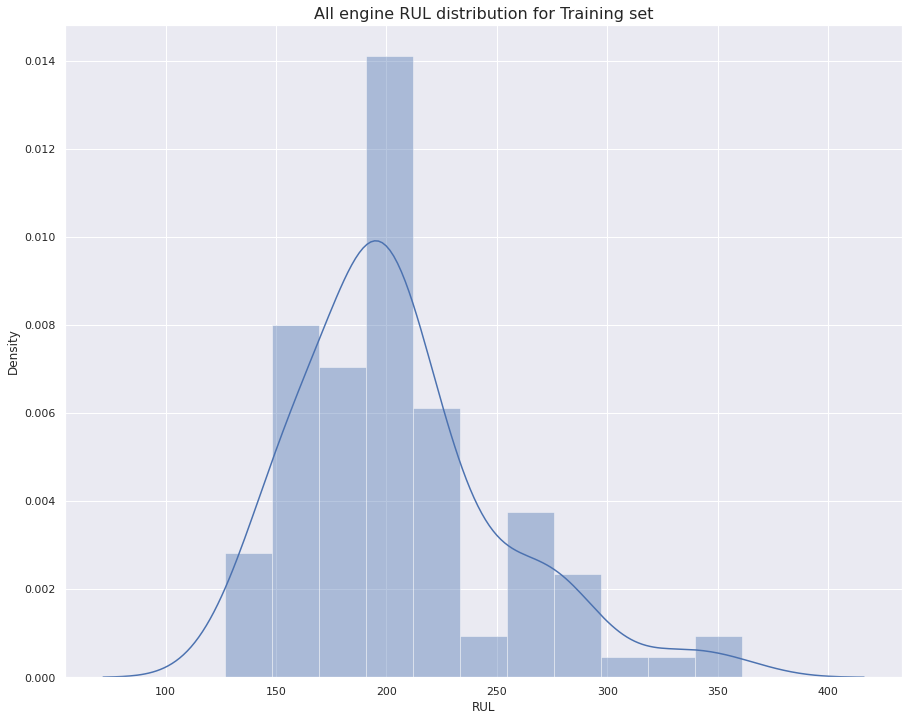

In [ ]:
fig = plt.figure(figsize=(15,12))
ax = sns.distplot(RUL)
ax.set_title('All engine RUL distribution for Training set', {'fontsize': 16});
ax.set_xlabel('RUL')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'RUL test')

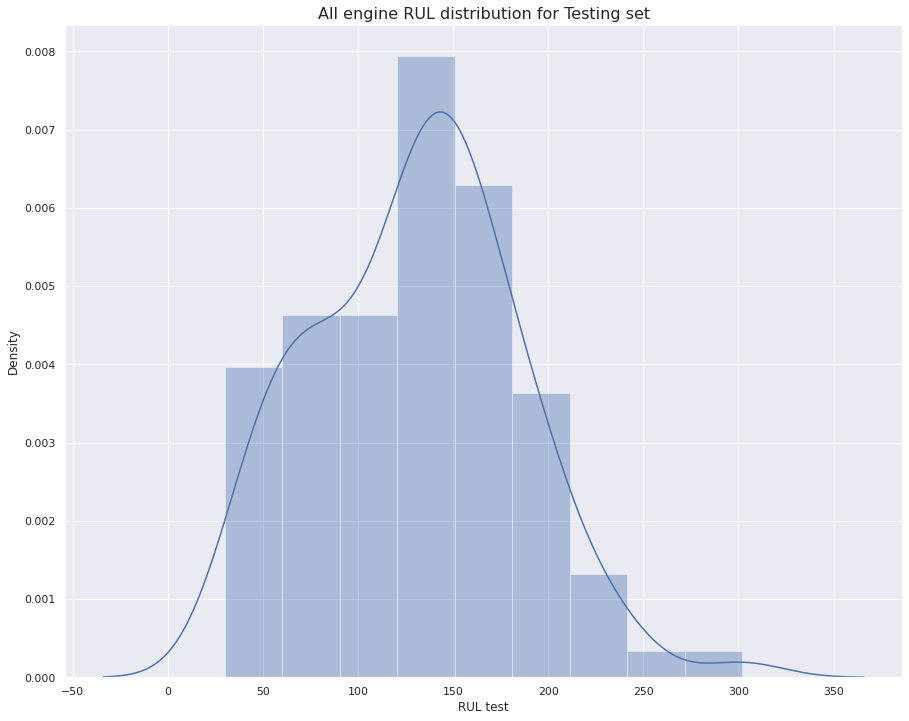

In [ ]:
fig = plt.figure(figsize=(15,12))
ax = sns.distplot(RUL_test)
ax.set_title('All engine RUL distribution for Testing set', {'fontsize': 16});
ax.set_xlabel('RUL test')

**To create the Health Index (HI) indicator we first need to train the extreme data (data at the beginning of the engine cycle and at the end of engine cycle life). Y's beginning of life gets 1, while end of life gets 0. 
The regression model takes sensor data and then gives fused HI indicator**

We need to define the extreme begining/end of life thresholds. I chose 300 for high and 5 for low. This thresholds are hyperparameters and their values can be optimized to get the optimal values.

In [ ]:
# conditions and thersholds for high HI and low HI
RUL_high = 300 # More that 300 cycles remaining until failure
RUL_low = 5 # Less that 5 cycles remaining unting failure
RUL_df = df['RUL'].values
RUL_df_test = testdf['RUL'].values

In [ ]:
# Getting high and low RUL indexes
# Train
idx_high_HI = [RUL_df <= - RUL_high][0]
idx_low_HI = [RUL_df > - RUL_low][0]
# Test
idx_high_HI_test = [RUL_df_test <= - RUL_high][0]
idx_low_HI_test  = [RUL_df_test > - RUL_low][0]

# Get in thresholds range data
# Train
high_HI_data = sensors_pca[idx_high_HI, :]
low_HI_data = sensors_pca[idx_low_HI, :]
# Test
high_HI_data_test = sensors_pca_test[idx_high_HI_test, :]
low_HI_data_test = sensors_pca_test[idx_low_HI_test, :]

# concatenate high HI and Low HI data
#Train
X_HI = np.concatenate((high_HI_data, low_HI_data), axis=0)
#Test
X_HI_test = np.concatenate((high_HI_data_test, low_HI_data_test), axis=0)

# Y one and zeros
#Train
y_1 = np.ones(high_HI_data.shape[0])
y_0 = np.zeros(low_HI_data.shape[0])
#Test
y_1_test = np.ones(high_HI_data_test.shape[0])
y_0_test = np.zeros(low_HI_data_test.shape[0])
# concatenate high HI and Low HI Ys
#Train
y_HI = np.concatenate((y_1, y_0), axis=0)
#Test
y_HI_test = np.concatenate((y_1_test, y_0_test), axis=0)

In the paper they used 2 types of models to predict the HI: Linear regression, and logistic regression. I'm going to use them as well.

In [ ]:
# linear regression
HI_linear = LinearRegression()
HI_linear.fit(X_HI, y_HI)
# logistic regression
HI_logistic = LogisticRegression(solver='liblinear')
HI_logistic.fit(X_HI, y_HI)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

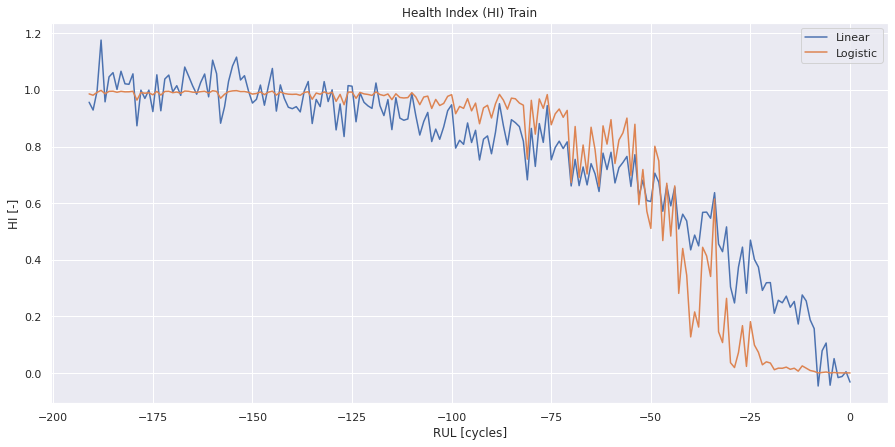

In [ ]:
engine_num = 1
engine_sensors = sensors_pca[engine_slices[engine_num], :]
engine_sensors_test = sensors_pca_test[engine_slices_test[engine_num], :]
RUL_engine = df.loc[engine_num]['RUL']
RUL_engine_test = testdf.loc[engine_num]['RUL']

# predict the HI
HI_pred_lin = HI_linear.predict(engine_sensors)
HI_pred_log = HI_logistic.predict_proba(engine_sensors)[:,1]

#predict the HI for test data
HI_pred_lin_test = HI_linear.predict(engine_sensors)
HI_pred_log_test = HI_logistic.predict_proba(engine_sensors_test)[:,1]

# plot fused HI signal for linear and logistic models (Train)
fig = plt.figure(figsize=(15,7))
plt.plot(RUL_engine, HI_pred_lin, label='Linear')
plt.plot(RUL_engine, HI_pred_log, label='Logistic')
plt.title('Health Index (HI) Train')
plt.xlabel('RUL [cycles]')
plt.ylabel('HI [-]')
plt.legend()

**The Health Indicator is visibly a good heath indicator, in fact we can see that in the begining of life the HI is high and then decreases until reaching 0 in end of life.\
However we notice that the HI is not stable and shows a lot of oscillations, so we need to smooth its values.**

#### Smoothing the HI

In [ ]:
# exponential smoothing
exp_smooth = ExponentialSmoothing(HI_pred_lin, trend='add')
exp_smooth.fit()
Holt = HoltWintersResults(exp_smooth, exp_smooth.params)
y_exp = Holt.predict(0, len(HI_pred_lin)-1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [ ]:
# find odd window length for filtering
percent_n_smaple = 0.15
temp_window = int(len(HI_pred_lin) * percent_n_smaple)
if temp_window % 2 == 0:
    window = temp_window - 1
else:
    window = temp_window
# apply savgol_filter to the signal
y_filter = savgol_filter(HI_pred_lin, window_length=window, polyorder=3)

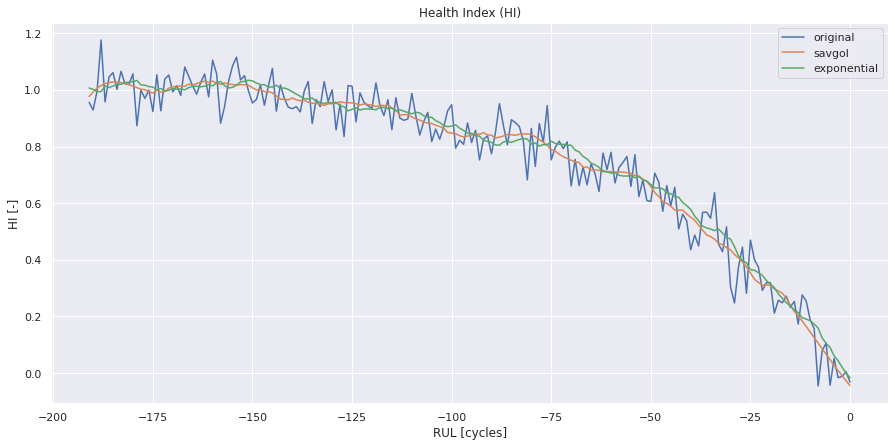

In [ ]:
# plot fused HI signal with the smoothed signals
fig = plt.figure(figsize=(15,7))
plt.plot(RUL_engine, HI_pred_lin, label='original')
plt.plot(RUL_engine, y_filter, label='savgol')
plt.plot(RUL_engine, y_exp, label='exponential')
plt.title('Health Index (HI)')
plt.xlabel('RUL [cycles]')
plt.ylabel('HI [-]')
plt.legend();

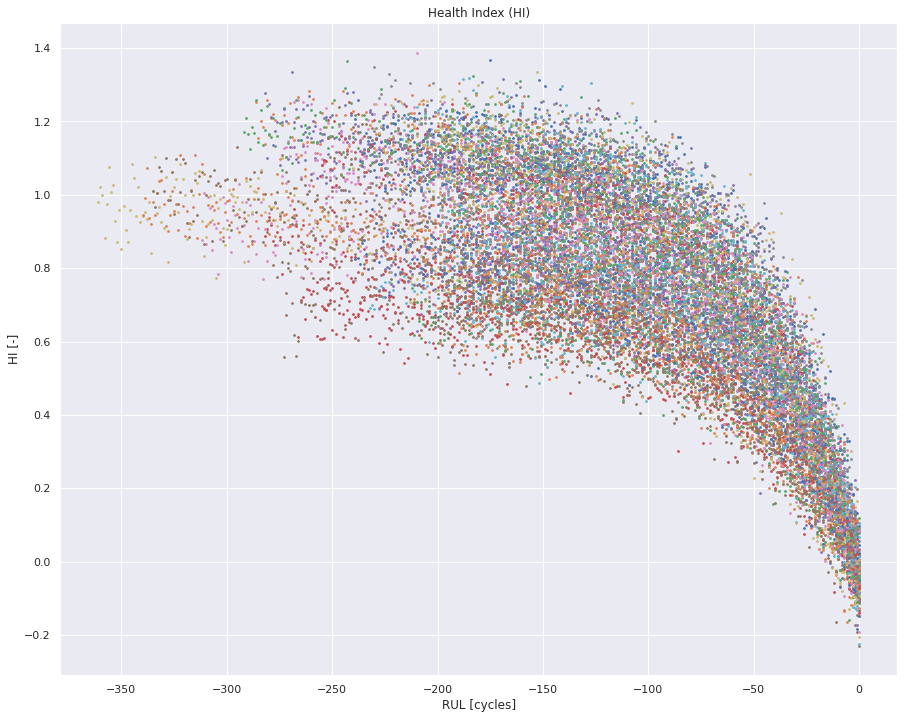

In [ ]:
# plot HI for all engines 
fig = plt.figure(figsize=(15, 12))
for engine_num in engines:
    engine_sensors = sensors_pca[engine_slices[engine_num], :]
    RUL_engine = df.loc[engine_num]['RUL']
    # predict the HI
    HI_pred_lin = HI_linear.predict(engine_sensors)   
    plt.scatter(RUL_engine, HI_pred_lin, label=engine_num, s=3)
    plt.title('Health Index (HI)')
    plt.xlabel('RUL [cycles]')
    plt.ylabel('HI [-]')

### curve fit the  Health Index (HI) with exponential function 

In [ ]:
def exp_func(x, a, b):
    return a * (np.exp(b * x)-1)

In [ ]:
# row of all the health index for all engines
HI_linear_df = HI_linear.predict(sensors_pca) 
HI_linear_df_test = HI_linear.predict(sensors_pca_test)

In [ ]:
# prepare sample data for fitting function 
engine_num = 1
engine_idx = engine_slices[engine_num]
xdata = RUL_df[engine_idx]
y = HI_linear_df[engine_idx]

In [ ]:
popt, _= curve_fit(exp_func, xdata, y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


### plot HI [ raw , smoothed, exponential fitting] 

In [ ]:
# find odd window length for filtering
percent_n_smaple = 0.15
temp_window = int(len(y) * percent_n_smaple)
if temp_window % 2 == 0:
    window = temp_window - 1
else:
    window = temp_window
# apply savgol_filter to the signal
y_filter = savgol_filter(y, window_length = window, polyorder = 3)

In [ ]:
# compute the exponential model curve 
y_exp_model = exp_func(xdata, * popt)

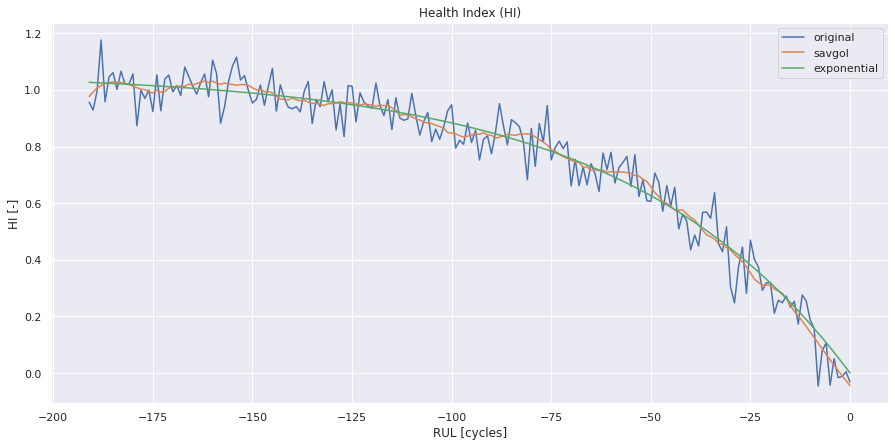

In [ ]:
fig = plt.figure(figsize=(15,7))
plt.plot(xdata, y, label='original')
plt.plot(xdata, y_filter, label='savgol')
plt.plot(xdata, y_exp_model, label='exponential')
plt.title('Health Index (HI)')
plt.xlabel('RUL [cycles]')
plt.ylabel('HI [-]')
plt.legend();

### Create an exponential model for each engine [ these are used for similarity comparison later on testing]

In [ ]:
def train_HI_param(df,sensors,fuse_model):
    
    """
    fits an exponential curve to the health index for each engine. 
    outputs the two parameters for exponential function (a,b)
    y = a*[exp(b*cycles) - 1] 
    ========================================================================
    
    input: 
    df- (df) data frame for the raw sensors  that left after transformation 
    sensors - (ndarray) normalize sensor to use for analysis and prediction of RUL 
    fuse_model - (sklearn) Sciket learn a trained model that fuse multi-dimensional sensors into a one-dimensional sensor  
    
    output: 
    exp_param -(ndarray) fitted parameters of the exponential function of each engine (num_eigines, 2) each row is [a,b]
    """
    
    # get indexes and slices that are useful to capture the raw data for a specific engine
    engines=df.index.unique().values # engine numbers
    engine_slices = dict()# key is engine number, value is a slice that gives numpy index for the data that pertains to an engine  
    
    # find engine_slices
    for i,engine_num in enumerate(engines):
        row_name=df.loc[engine_num].iloc[-1].name
        row_sl=df.index.get_loc(row_name) # row slice to get numpy index 
        engine_slices[engine_num]=row_sl
    
    # parameters for exponential HI model
    exp_param = np.empty((len(engines),2))

    # fit exp curve to each engine data
    for i,engine in enumerate(engines):
        engine_idx=engine_slices[engine]
        engine_cycles=RUL_df[engine_idx] # this is RUL ( negative integers and last cycle has value of 0)
        fused_sensor=fuse_model.predict(sensors[engine_idx,:])
        popt,_ = curve_fit(exp_func, engine_cycles,fused_sensor)

        exp_param[i,:] = popt

    return exp_param    

In [ ]:
exp_param = train_HI_param(df,sensors_pca,HI_linear)

In [ ]:
HI_linear_df.shape

(20631,)

In [ ]:
# get the values of the fitted exp HI for all engines and put them in one array

HI_fitted_df = np.empty_like(HI_linear_df) 
for i, engine in enumerate(engines):
    engine_idx = engine_slices[engine]
    engine_cycles = RUL_df[engine_idx] # this is RUL ( negative integers and last cycle has value of 0)
    HI_fitted_df[engine_idx] = exp_func(engine_cycles, *exp_param[i,:])

**predicting new engine RUL - lookahead process** 

what comes next is the algorithm for predicting RUL for a new engine based on sensor values that have operating cycles less than the full life-cycle. 

I'll use mainly interpolation scheme to compare the new engine $y_{fused}$ with the library of health index models just obtained from training. 

## Similarity comparison to get RUL for a new engine ( from a test set)

### Exprimentation to devalop RUL_predict function

In [ ]:
# experiment with TimeSeriesSplit to prepare a synthetic testing engine 
engine_num = 79
engine_idx = engine_slices[engine_num]
engine_cycles = RUL_df[engine_idx]
split_ts = TimeSeriesSplit(n_splits=3)

In [ ]:
X = engine_cycles
y = HI_linear_df[engine_idx]
print('X has : {} cycles'.format(len(X)))
n = 0
for train_index, test_index in split_ts.split(X):
    n = n + 1
    percent = len(train_index)/len(X)
    print('Fold :{}'.format(n))
    print('X_train has : {} cycles'.format(len(train_index)))
    print('percentage of trainig cycles is {}'.format(percent))

X has : 199 cycles
Fold :1
X_train has : 52 cycles
percentage of trainig cycles is 0.2613065326633166
Fold :2
X_train has : 101 cycles
percentage of trainig cycles is 0.507537688442211
Fold :3
X_train has : 150 cycles
percentage of trainig cycles is 0.7537688442211056


In [ ]:
# fused is like a new engine in which its sensor got transformed to a fused signal using the linear model
cycles = X[train_index] 
# fused = y[train_index]
fused = y[26:170]

In [ ]:
# first smooth the data
def smooth_signal(sensor):
    """
    smooth the health index fused signal using savgol_filter
    ========================================================
    
    input: 
    sensor- (array) array with signal to be smothed 
    output:
    smooth -(array) same size as sensor and is the smoothed signal 
    """
    # find odd window length for filtering
    percent_n_smaple = 0.15
    temp_window = int(len(sensor) * percent_n_smaple)
    if temp_window %2 == 0:
        window = temp_window-1
    else:
        window = temp_window

    # apply savgol_filter to the signal
    smooth = savgol_filter(sensor, window_length=window,polyorder=3)

    return smooth

In [ ]:
fused_smooth = smooth_signal(fused)

#### RUL_pool

In [ ]:
def RUL_pool(fused_test, HI_lib, engine_slices):
    
    """
    finds RUL best estimate for each trained engine in the library
    ===============================================================
    
    input: 
    fused_test - (array) fused signal (HI) for a test engine 
    HI_lib -(array) health index values for each engine in our trained library
    engine_slices - (dict) key   : is engine number 
                           values: slices where each slice gives the indexes that can slice 
                           a specific engine data from HI_lib array
    output:
    RUL -(array) estimated  RUL for the test engine from each engine in the trained library length = len(engine_slices)
    SSD_min (array)
    total_life (array)

    """
    
    # initialize the output arrays
    RUL = np.empty(len(engine_slices))
    total_life = np.empty_like(RUL)
    SSD_min = np.empty_like(RUL)
    
    # smooth the test signal 
    fused_smooth = smooth_signal(fused_test)

    for i, engine in enumerate(engine_slices):
        HI_model = HI_lib[engine_slices[engine]] # HI model for an engine 
        
        # this if statement just in case if the training data is already shorter in cycles than the test data
        if len(fused_test) > len(HI_model):
            RUL[i] = 0
            total_life[i] = len(fused_smooth)+RUL[i]
            SSD_min[i] = np.linalg.norm((fused_smooth[0:len(HI_model)] - HI_model))
            continue
            
        dist_sqr = euclidean_distances(fused_smooth.reshape(-1, 1), HI_model.reshape(-1, 1), squared = True)

        # cycle gap parameter that is part of similarity calcualtion 
        diff_cycle = len(HI_model) - len(fused_smooth)
        diag_offset = list(range(0, diff_cycle + 1)) # cycle gap parameter values

        # find distance between the test engine curve and model curve (SSD) for every cycle gap parameter
        SSD=np.array([np.trace(dist_sqr,k) for k in  diag_offset]) # Sum of Squared Differences
        SSD_min[i] = SSD.min() # minimum Sum of Squared Differences (the similarity metric low means very similar)
        T0 =  SSD.argmin() # optimum cycle gap parameter

        RUL[i] = diff_cycle - T0
        total_life[i] = len(fused_smooth) + RUL[i]
    
    return RUL, SSD_min, total_life

In [ ]:
RUL_pooled, SSD_min, total_life = RUL_pool(fused_smooth, HI_fitted_df, engine_slices)

In [ ]:
RUL_pooled

array([ 48.,  54.,  23.,  41.,  49.,  44.,  67.,   6.,  14.,  36.,  39.,
        26.,  19.,  36.,  33.,  65.,  47.,  18.,  14.,  90.,  51.,  58.,
        24.,   3.,  86.,  55.,  12.,  19.,  19.,  25.,  45.,  47.,  28.,
        51.,  37.,  14.,  26.,  50.,   0.,  44.,  43.,  52.,  43.,  38.,
        14.,  55.,  39.,  22.,  71.,  54.,  17.,  69.,  51.,  44.,  49.,
       131.,   0.,   3.,  37.,  28.,  22.,  36.,  30., 139.,   9.,  58.,
       169.,  55., 179.,   0.,  64.,  69.,  69.,  22.,  85.,  66.,  10.,
        37.,  29.,  41.,  96.,  21.,  54., 123.,  44., 134.,  34.,  60.,
        53.,  10.,   0., 145.,  11., 114.,  56., 133.,  23.,  12.,  41.,
        56.])

#### Helper functions for RUL_predict

In [ ]:
def RUL_similarity_filter(distance, max_distance = 8, min_rows = 12):
    
    """
    select top RUL candidate from RUL pool based on similarity scores
    ===============================================================
    
    input: 
    distance - (array) Sum of Squared Differences (distance) of the test HI from each engine HI model in the library 
    max_distance -(float) > 1 factor to select rows from 'distance' that satisfies: distance < 'max_distance' * min('distance')
    min_rows - (int) minimum RUL candidate to select from RUL pool 
    
    output:
    idx -(array) indexes of the selected 'distance'
    """
    
    # selects rows that have cutoff distance   set to a 'max_distance'*100% increase of the smallest score (d1)
    d1 = distance.min()
    idx = np.where(distance < max_distance * d1)[0]
    
    if len(idx) < min_rows:
        idx = np.argsort(distance)[0:min_rows]

    return idx

In [ ]:
RUL_similarity_filter(SSD_min, max_distance = 5.5, min_rows = 12)

array([78, 14, 77, 32, 29, 58, 81,  9, 60, 46, 30,  8])

In [ ]:
def RUL_stat_filter(RUL_pooled,total_life,RUL_max=180,life_min=125):
    
    """
    filters RUL candidate from RUL pool based on statistical observation of the RUL distribution from all engines 
    ===========================================================================================================
    
    input: 
    RUL_pooled - (array) estimated RUL for the test engine from each engine in the library 
    total_life -(array)  estimated  total life for the test engine from each engine in the library
    RUL_max- (int)    : maximum RUL above which I consider the prediction large (since probably extrapolate too much in future)- based on roughly the mean of RUL distribution 
    life_min - (int) minimum life of test engine. This comes from RUL distribution obtained from training set
    
    output:
    idx -(array) indexes of the selected rows of 'RUL_pooled'
    """
    idx1 = np.where(RUL_pooled <= RUL_max)[0]
    idx2 = np.where(total_life >= life_min)[0]
    idx  = np.intersect1d(idx1,idx2)
    
    return idx

In [ ]:
np.floor(np.median(RUL_stat_filter(RUL_pooled,total_life, RUL_max = 110, life_min = 125) + .66))

45.0

In [ ]:
((1.0/SSD_min).T @ RUL_pooled)/(1.0/SSD_min).sum()

33.03199029054316

### RUL_predict function

In [ ]:
def RUL_predict(RUL_pooled,distance,total_life,method=1,max_distance=8,min_rows=12,RUL_max=180,life_min=125):
    
    """
    fuse multiple RUL estimate from all engines into the final prediction RUL of a testunit 
    ===========================================================================================================
    
    input: 
    RUL_pooled - (array) estimated RUL for the test engine from each engine in the library 
    distance - (array) Sum of Squared Differences (distance) of the test HI from each engine HI model in the library 
    total_life -(array)  estimated  total life for the test engine from each engine in the library
    method - (int) flag to determine which method to use to fuse multiple RUL predictions
    
                    method = 1, final_RUL = median of values 
                    method = 2, final_RUL = weighted mean of values weights based on similarity score 
                    method = 3, final_RUL = weighted mean of max and min two values weights based on PHM score
                    method = 4, final_RUL = mean of values
                    
    RUL_max- (int)    : maximum RUL above which I consider the prediction large (since probably extrapolate too much in future)- based on roughly the mean of RUL distribution 
    life_min - (int) minimum life of test engine. This comes from RUL distribution obtained from training set
    max_distance -(float) > 1 factor to select rows from 'distance' that satisfies: distance< 'max_distance' * min('distance')
    min_rows - (int) minimum RUL candidate to select from RUL pool

    output:
    final_RUL -(int) final predicted RUL for a test unit
    """
    # filter RUL_pooled based on similarity score 
    similarity_filter_idx = RUL_similarity_filter(distance, max_distance, min_rows)
    final_RUL = RUL_pooled[similarity_filter_idx]
    final_distance = distance[similarity_filter_idx]
    final_total_life = total_life[similarity_filter_idx]
    
    # filter final_RUL based on stat_filter
    stat_filter_idx = RUL_stat_filter(final_RUL, final_total_life, RUL_max, life_min)
    final_RUL = final_RUL[stat_filter_idx]
    final_distance = final_distance[stat_filter_idx]
    final_total_life = final_total_life[stat_filter_idx]
    
    # fusing final_RUL:
    
    if method == 1: # median
        final_RUL = np.floor(np.median(final_RUL))
        
    elif method == 2: # weighted mean based on distance
        w = 1./final_distance # weights
        sum_w = w.sum()
        final_RUL = (w.T @ final_RUL) / sum_w
        final_RUL = np.floor(final_RUL)
            
    elif method == 3: # mean of max and min
        w = np.array([13.0,10.0 ]) # weights
        sum_w = w.sum()
        final_RUL = np.array([final_RUL.min(), final_RUL.max()])
        final_RUL = (w.T @ final_RUL) / sum_w
        final_RUL = np.floor(final_RUL)
    else: # simple mean
        final_RUL = np.floor(final_RUL.mean())
            
    return final_RUL

### Score function

In [ ]:
def penalty_score(estimated_RUL, true_RUL):
    
    """
    computes penalty score of RUL prediction (main metric of the algorithm) 
    ===========================================================================================================
    
    input: 
    estimated_RUL - (float/array) estimated RUL for the test engine  
    true_RUL - (float/array) true RUL for the test engine  

    output:
    S -(float/array) asymmetric penalty score of the algorithm  
    
    """
    error = np.array(estimated_RUL) - np.array(true_RUL)
    error = np.array(error)
    S1 = np.heaviside(error,0) * (np.exp(error/10) - 1) # postive errors
    S2 = np.heaviside(-1*error, 0) * (np.exp(-1*error/13) - 1) # negative errors
    S = S1 + S2 

    return S

In [ ]:
n_engines = 100
predicted_RULs = []
true_RULs = []
percent = .9 # percentage to keep
for i in range(1, n_engines+1):
  # experiment RUL_predict

  # get data and keep a certian percentage [ simulate a testing engine]
  engine_num = i
  engine_idx = engine_slices[engine_num]
  y = HI_linear_df[engine_idx] # full data 
  last_cycle = np.floor(len(y)*percent)
  true_RUL = len(y) - last_cycle # current true RUL for truncated data

  # test data
  y_test = y[0:int(last_cycle)]

  # smooth the test data
  y_test_smooth = smooth_signal(y_test)
  # y_test_smooth = y_test

  # get pooled estiamte from model
  RUL_pooled, distance, total_life = RUL_pool(y_test_smooth, HI_fitted_df, engine_slices)
  estimated_RUL = RUL_predict(RUL_pooled,distance,total_life,method=2)
  predicted_RULs.append(estimated_RUL)
  true_RULs.append(true_RUL)

In [ ]:
HI_linear_df_test.shape, HI_linear_df.shape

((13096,), (20631,))

In [ ]:
n_engines = 100
predicted_RULs = []
true_RULs = []
percent = 0.8 # percentage to keep
for i in range(1, n_engines+1):
  # experiment RUL_predict

  # get data and keep a certian percentage [ simulate a testing engine]
  engine_num = i
  engine_idx = engine_slices[engine_num]
  y = HI_linear_df[engine_idx] # full data 
  last_cycle = np.floor(len(y) * percent)
  true_RUL = len(y) - last_cycle # current true RUL for truncated data

  # test data
  y_test = y[0:int(last_cycle)]
  # smooth the test data
  if len(y_test) > 0:
    y_test_smooth = smooth_signal(y_test)

  # get pooled estiamte from model
  RUL_pooled, distance, total_life = RUL_pool(y_test_smooth, HI_fitted_df, engine_slices)
  estimated_RUL = RUL_predict(RUL_pooled,distance,total_life,method=1)
  predicted_RULs.append(estimated_RUL)
  true_RULs.append(true_RUL)

In [ ]:
def score(estimated_RUL, true_RUL):
  import math
  estimated_RUL = np.array(estimated_RUL)
  true_RUL = np.array(true_RUL) 
  d = estimated_RUL - true_RUL
  scores = []
  for i in range(len(d)):
    if d[i] < 0: 
      exposant = -(d[i]/13)  ### cas favorable 
    else: 
      exposant = (d[i]/10)   ### cas défavorable
    score = math.exp(exposant) - 1
    scores.append(score)
  return sum(scores)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    abs_diff = np.abs(y_true - y_pred)
    div = abs_diff / y_true
    print(y_pred)
    print(y_true)
    return np.mean(div) * 100

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
mean_squared_error(true_RULs, predicted_RULs), mean_absolute_percentage_error(true_RULs, predicted_RULs), mean_absolute_error(true_RULs, predicted_RULs), score(predicted_RULs, true_RULs)

[37. 27. 56. 74. 43. 38. 39. 44. 83. 54. 54. 35. 50. 40. 46. 31. 51. 58.
 38. 43. 52. 33. 34. 41. 48. 51. 44. 47. 38. 54. 52. 39. 51. 51. 44. 29.
 31. 47. 37. 38. 45. 35. 49. 40. 41. 46. 40. 69. 39. 41. 71. 45. 44. 52.
 78.  5. 34. 37. 53. 42. 57. 38. 50. 21. 48. 30. 14. 56.  0. 40. 51. 35.
 31. 40. 42. 36. 41. 54. 48. 59. 47. 69. 11.  8. 36. 30. 35. 43. 38. 44.
 33.  0. 37. 23. 38.  0. 55. 37. 38. 34.]
[39. 58. 36. 38. 54. 38. 52. 30. 41. 45. 48. 34. 33. 36. 42. 42. 56. 39.
 32. 47. 39. 41. 34. 30. 46. 40. 32. 33. 33. 39. 47. 39. 40. 39. 37. 32.
 34. 39. 26. 38. 44. 40. 42. 39. 32. 52. 43. 47. 43. 40. 43. 43. 39. 52.
 39. 55. 28. 30. 47. 35. 37. 36. 35. 57. 31. 41. 63. 40. 73. 28. 42. 43.
 43. 34. 46. 42. 31. 47. 40. 37. 48. 43. 59. 54. 38. 56. 36. 43. 44. 31.
 27. 69. 31. 52. 57. 68. 41. 32. 37. 40.]


(416.66, 30.164479788535182, 13.5, 1164.1195178025928)

In [ ]:
estimated_RUL

In [ ]:
true_RUL

0.0

In [ ]:
penalty_score(estimated_RUL,true_RUL)

0.22140275816016985

# Refinement

**the effect of various method to fuse the estimated RUL is investigated here on the training set to see which method gives best results. also, smoothing the data before making the estimation is investigated. truncated data with various length is used to see the algorithm robustness**

In [ ]:
def model_performance(HI_linear_df, HI_fitted_df, engine_slices, engines, percents, methods=1, smooth=True):
    
    """
    evaluates the penalty score by truncating the training data for all engines by various amounts.
    this allows testing the method and smooth parameters of the algorithm for refinement on the algorithm.   
    ========================================================================
    
    input: 
    HI_linear_df- (array)  
    HI_fitted_df - (array) 
    engine_slices - (dict)
    engines - (list) engine numebrs
    percents - (list) list of percentage values of how much to keep from original data (simulated testing data)
    methods - (int) [1,2,3,4]
    smooth-(bool)
    
    output: 
    scores -(ndarray) penalty score for all combinations of percentages and engines 
    errors -(ndarray) errors for all combinations of percentages and engines 
    """
    # initilize the scores and errors 
    n_engines = len(engines)
    n_percents = len(percents)
    scores = np.empty((n_engines,n_percents))
    errors = np.empty_like(scores)
    
    # loop through all engines in training set
    for i,engine in enumerate(engines):
        engine_idx = engine_slices[engine]

        # get data and keep a certian percentage [ simulate a testing engine]
        y = HI_linear_df[engine_idx] # full data 
        
        # loop through each percentage value
        for j,percent in enumerate(percents):
            last_cycle = np.floor(len(y)*percent)
            true_RUL = len(y)-last_cycle # current true RUL for truncated data

            # test data
            y_test = y[0:int(last_cycle)]

            # smooth the test data
            if smooth:
                y_test = smooth_signal(y_test)
                
            # get RUL estiamte and error
            RUL_pooled,distance,total_life=RUL_pool(y_test, HI_fitted_df, engine_slices)
            estimated_RUL = RUL_predict(RUL_pooled,distance, total_life, method=methods)
            error = estimated_RUL - true_RUL
            
            # penalty score
            score = penalty_score(estimated_RUL,true_RUL)
            
            # fill the outputs
            scores[i,j] = score
            errors[i,j] = error

    return scores, errors    

## Method 1  Refinement

In [ ]:
method = 1
percents = [.5,.6,.7,.8,.9]
smooth = True
# smooth method 1 
method1_score_sm,method1_error_sm=model_performance(
    HI_linear_df, HI_fitted_df, engine_slices, engines, percents, methods=method, smooth=smooth)
smooth = False
# without smooth
method1_score, method1_error = model_performance(
    HI_linear_df, HI_fitted_df, engine_slices, engines, percents, methods=method, smooth=smooth)

## Method 2  Refinement

In [ ]:
method = 2
percents = [.5,.6,.7,.8,.9]
smooth = True
# smooth method 2 
method2_score_sm, method2_error_sm = model_performance(
    HI_linear_df, HI_fitted_df, engine_slices, engines, percents, methods=method, smooth=smooth)

smooth = False
# smooth method 2 
method2_score, method2_error = model_performance(
    HI_linear_df, HI_fitted_df, engine_slices, engines, percents, methods=method, smooth=smooth)

## Method 3  Refinement

In [ ]:
method = 3
percents = [.5,.6,.7,.8,.9]
smooth = True
# smooth method 3 
method3_score_sm, method3_error_sm = model_performance(
    HI_linear_df, HI_fitted_df, engine_slices, engines, percents, methods=method, smooth=smooth)

smooth = False
# smooth method 3 
method3_score,method3_error = model_performance(
    HI_linear_df, HI_fitted_df, engine_slices, engines, percents, methods=method, smooth=smooth)

## Method 4  Refinement

In [ ]:
method = 4
percents = [.5,.6,.7,.8,.9]
smooth = True
# smooth method 4 
method4_score_sm, method4_error_sm = model_performance(
    HI_linear_df, HI_fitted_df, engine_slices, engines, percents, methods=method, smooth=smooth)

smooth = False
# smooth method 4 
method4_score, method4_error = model_performance(
    HI_linear_df, HI_fitted_df, engine_slices, engines, percents, methods=method, smooth=smooth)

### Method 1 smooth / no-smooth comapre

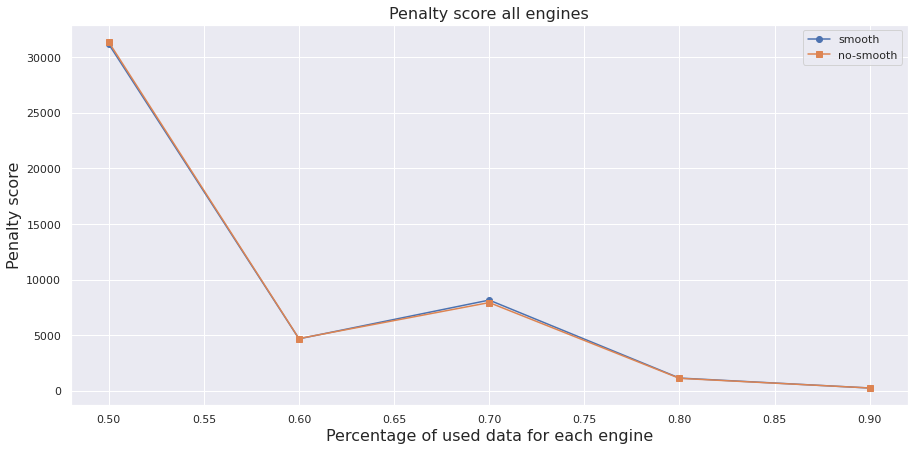

In [ ]:
fig = plt.figure(figsize=(15,7))
plt.plot(percents, method1_score_sm.sum(axis=0), '-o', label='smooth')
plt.plot(percents, method1_score.sum(axis=0), '-s', label='no-smooth')
plt.title('Penalty score all engines', {'fontsize':16});
plt.ylabel('Penalty score', {'fontsize':16});
plt.xlabel('Percentage of used data for each engine', {'fontsize':16});
plt.legend()
plt.show()

## All Methods comapre smooth = True

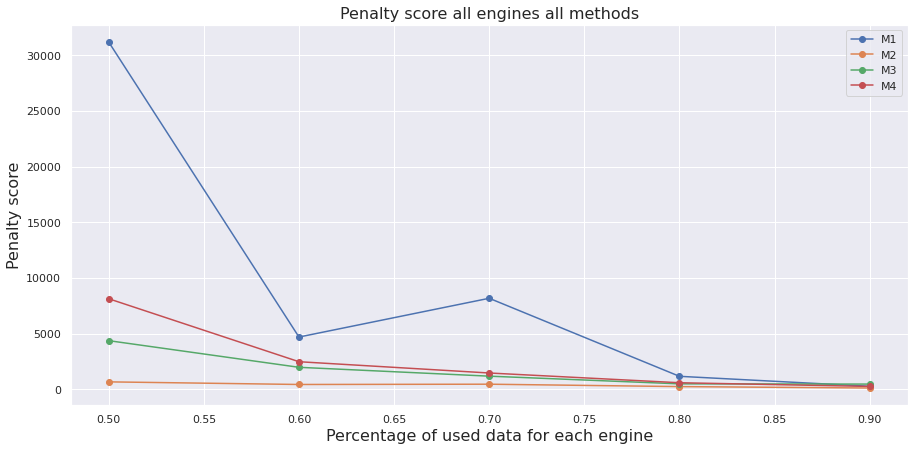

In [ ]:
fig=plt.figure(figsize=(15,7))

plt.plot(percents, method1_score_sm.sum(axis=0), '-o', label='M1')
plt.plot(percents, method2_score_sm.sum(axis=0), '-o', label='M2')
plt.plot(percents, method3_score_sm.sum(axis=0), '-o', label='M3')
plt.plot(percents, method4_score_sm.sum(axis=0), '-o', label='M4')
plt.title('Penalty score all engines all methods', {'fontsize':16});
plt.ylabel('Penalty score',{'fontsize':16});
plt.xlabel('Percentage of used data for each engine', {'fontsize':16});
plt.legend()
plt.show()